In [21]:
# Importing the required objects from libraries for learning the sampleEducbaSequence
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import random
from tensorflow import keras
from tensorflow.keras import layers
from pandas import DataFrame
from pandas import concat
# from tensorflow.keras.Model import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM
from tensorflow.keras.models import Sequential
from sklearn.preprocessing import MinMaxScaler
from sklearn.utils import shuffle
from sklearn.metrics import mean_absolute_percentage_error
from statsmodels.tsa.stattools import adfuller

from sktime.transformations.series.adapt import PandasTransformAdaptor
from sktime.utils import plotting
from sktime.forecasting.theta import ThetaForecaster
from sktime.forecasting.exp_smoothing import ExponentialSmoothing
from sktime.performance_metrics.forecasting import mean_squared_error
from sktime.performance_metrics.forecasting import mean_absolute_percentage_error
from sktime.forecasting.croston import Croston
from sktime.datasets import load_PBS_dataset
from sktime.forecasting.arima import AutoARIMA
from sktime.datatypes import get_examples
from sktime.datatypes import check_raise
from sktime.datasets import load_airline
from sktime.utils.plotting import plot_series
from sktime.transformations.series.difference import Differencer
from sktime.transformations.compose import InvertTransform
from sktime.forecasting.compose import TransformedTargetForecaster
from sktime.transformations.series.detrend import Deseasonalizer
from sktime.forecasting.trend import PolynomialTrendForecaster
from sktime.transformations.series.detrend import Detrender
from sktime.forecasting.compose import ForecastingPipeline
from sktime.transformations.series.boxcox import LogTransformer
from sktime.transformations.series.acf import AutoCorrelationTransformer
from sktime.transformations.series.impute import Imputer
from sktime.forecasting.model_selection import ExpandingWindowSplitter
from sktime.forecasting.model_selection import ForecastingGridSearchCV
from sktime.transformations.series.boxcox import BoxCoxTransformer
from sktime.performance_metrics.forecasting import MeanAbsolutePercentageError
from sktime.transformations.compose import TransformerPipeline
from sktime.transformations.series.adapt import TabularToSeriesAdaptor

tf.keras.backend.clear_session()
# tf.compat.v1.disable_eager_execution() #IF ERROR, UNCOMMENT
tf.keras.backend.clear_session()
tf.compat.v1.disable_eager_execution() #IF ERROR, UNCOMMENT

In [12]:
productNumber = "12141"
datasetTarget="/home/esteban/Documents/Optimix/DeepAR/tools/correctedsupplyProduct_"+productNumber+".csv"
dataframe = pd.read_csv(datasetTarget, header=0, index_col=0)
dataframe.columns = ["value"]
prediction_size = 26
sp = 52
look_back = 14
batch_size = 15

# Inputs creation
# dataframe = pd.read_csv('AirPassengers.csv', usecols=[1], engine='python')
tf.random.set_seed(7) #fix randomity
dataset = dataframe.values
dataset = dataset.astype('float32')

pipe = TransformerPipeline(steps=[
        ("imputer", Imputer(method="mean")),
#         ("minmaxscaler", TabularToSeriesAdaptor(MinMaxScaler())),
        ("boxcox", BoxCoxTransformer()),
        ("deseasonalize", Deseasonalizer(model="additive", sp=sp)),
        ("detrend", Detrender(forecaster=PolynomialTrendForecaster(degree=2))),
#     ("differencer", Differencer(lags=1, na_handling='fill_zero')),
#     ("forecaster", NaiveForecaster(strategy="drift")),
])
dataset = pipe.fit_transform(dataset)
# print(dataset)
# normalize the dataset
# scaler = MinMaxScaler(feature_range=(0, 1))
# dataset = scaler.fit_transform(dataset)


# split into train and test sets
train_size = int(len(dataset) * 0.67)
test_size = len(dataset) - train_size
train, test = dataset[0:train_size,:], dataset[train_size:len(dataset),:]
print(len(train), len(test))


105 52


ADF Statistic: -14.526724134836238
n_lags: 5.4133384714893446e-27
p-value: 5.4133384714893446e-27
Critial Values:
   1%, -3.4729792729247793
Critial Values:
   5%, -2.8802520918255534
Critial Values:
   10%, -2.5767469641683105


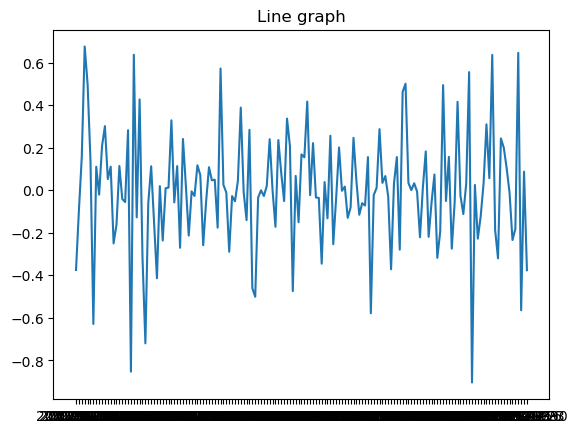

In [13]:
# ADF Test
result = adfuller(dataset, autolag='AIC')
print(f'ADF Statistic: {result[0]}')
print(f'n_lags: {result[1]}')
print(f'p-value: {result[1]}')
for key, value in result[4].items():
    print('Critial Values:')
    print(f'   {key}, {value}')   
    
plt.title("Line graph")
plt.plot(dataframe.index, dataset)
# plt.grid(which="both")
plt.show()

In [14]:

# convert an array of values into a dataset matrix
def create_dataset(dataset, look_back=1):
     dataX, dataY = [], []
     for i in range(len(dataset)-look_back-1):
         a = dataset[i:(i+look_back), 0]
         dataX.append(a)
         dataY.append(dataset[i + look_back, 0])
     return np.array(dataX), np.array(dataY)

# reshape into X=t and Y=t+1
trainX, trainY = create_dataset(train, look_back)
testX, testY = create_dataset(test, look_back)
# testX = testX.reshape(len(testX), 1, 1)
# print(testX,testY)
# trainX = np.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
# testX = np.reshape(testX, (testX.shape[0], 1, testX.shape[1]))

trainX = np.reshape(trainX, (trainX.shape[0], trainX.shape[1], 1))
testX = np.reshape(testX, (testX.shape[0], testX.shape[1], 1))

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (15, 50)                  10400     
                                                                 
 dense (Dense)               (15, 1)                   51        
                                                                 
Total params: 10,451
Trainable params: 10,451
Non-trainable params: 0
_________________________________________________________________


2023-01-16 15:59:46.191981: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-01-16 15:59:46.192451: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.


None
(90, 14, 1)
Train on 90 samples
Epoch 1/5000


2023-01-16 15:59:46.537028: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.
2023-01-16 15:59:46.545463: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:354] MLIR V1 optimization pass is not enabled


90/90 - 0s - loss: 252.0251 - accuracy: 0.0000e+00 - 153ms/epoch - 2ms/sample
Epoch 2/5000
90/90 - 0s - loss: 194.7034 - accuracy: 0.0000e+00 - 10ms/epoch - 115us/sample
Epoch 3/5000
90/90 - 0s - loss: 253.1154 - accuracy: 0.0000e+00 - 10ms/epoch - 115us/sample
Epoch 4/5000
90/90 - 0s - loss: 144.5785 - accuracy: 0.0000e+00 - 10ms/epoch - 112us/sample
Epoch 5/5000
90/90 - 0s - loss: 146.6189 - accuracy: 0.0000e+00 - 12ms/epoch - 133us/sample
Epoch 6/5000
90/90 - 0s - loss: 153.5113 - accuracy: 0.0000e+00 - 11ms/epoch - 121us/sample
Epoch 7/5000
90/90 - 0s - loss: 102.6282 - accuracy: 0.0000e+00 - 10ms/epoch - 110us/sample
Epoch 8/5000
90/90 - 0s - loss: 113.8286 - accuracy: 0.0000e+00 - 11ms/epoch - 122us/sample
Epoch 9/5000
90/90 - 0s - loss: 114.3495 - accuracy: 0.0000e+00 - 11ms/epoch - 118us/sample
Epoch 10/5000
90/90 - 0s - loss: 120.6592 - accuracy: 0.0000e+00 - 10ms/epoch - 113us/sample
Epoch 11/5000
90/90 - 0s - loss: 101.2316 - accuracy: 0.0000e+00 - 10ms/epoch - 116us/sample


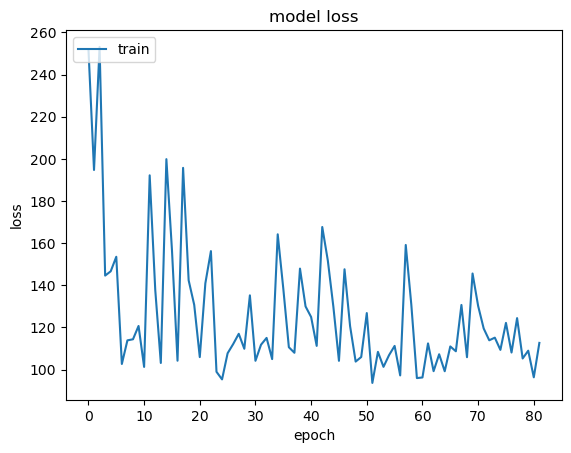

In [15]:
callbacks = [
    tf.keras.callbacks.EarlyStopping(patience=30, monitor="loss",min_delta=0.000000001)
]

def buildModel(neurons = 5, batch_size = 1, timestep = 1, features = 1):
    model = Sequential()
    model.add(LSTM(neurons, 
                   batch_input_shape=(batch_size, timestep, features), 
                   #return_sequences= True,
                   stateful=True))

    model.add(Dense(1))
    model.compile(loss='mean_absolute_percentage_error', optimizer='adam',  
                  metrics=['accuracy'])
#     model.compile(loss='mean_absolute_percentage_error', optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3))
    return model


# create and fit the LSTM network
model = buildModel(50,batch_size,look_back,1)
print(model.summary())
print(trainX.shape)
history = model.fit(trainX, trainY, epochs=5000, batch_size=batch_size, verbose=2,callbacks=callbacks)

tf.keras.utils.plot_model(model, show_shapes=True)
plt.plot(history.history['loss'])
# plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [16]:
# make predictions
trainPredict = model.predict(trainX)
testPredict = model.predict(testX)

/home/esteban/anaconda3/envs/Keras/lib/python3.10/site-packages/keras/engine/training_v1.py:2356: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,


InvalidArgumentError: Specified a list with shape [15,1] from a tensor with shape [7,1]
	 [[{{node lstm/TensorArrayUnstack/TensorListFromTensor}}]]

In [ ]:
# invert predictions
# trainPredict = scaler.inverse_transform(trainPredict)
# trainY = scaler.inverse_transform([trainY])
# testPredict = scaler.inverse_transform(testPredict)
# testY = scaler.inverse_transform([testY])
trainPredictInv = pipe.inverse_transform(trainPredict)
# print(trainY)
trainYInv = pipe.inverse_transform(trainY)
# print(trainY)
testPredictInv = pipe.inverse_transform(testPredict)
testYInv = pipe.inverse_transform(testY)

In [ ]:
# calculate root mean squared error
# print(trainY, trainPredict[:,0])
trainScore = np.sqrt(mean_absolute_percentage_error(trainYInv, trainPredictInv[:,0]))
print('Train Score: %.2f MAPE' % (trainScore))
testScore = np.sqrt(mean_absolute_percentage_error(testYInv, testPredictInv[:,0]))
print('Test Score: %.2f MAPE' % (testScore))

In [ ]:

# shift train predictions for plotting
trainPredictPlot = np.empty_like(dataset)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[look_back:len(trainPredictInv)+look_back, :] = trainPredictInv
# shift test predictions for plotting
testPredictPlot = np.empty_like(dataset)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(trainPredictInv)+(look_back*2)+1:len(dataset)-1, :] = testPredictInv
# plot baseline and predictions
plt.plot(pipe.inverse_transform(dataset))
plt.plot(trainPredictPlot)
plt.plot(testPredictPlot)
plt.show()

In [17]:
# idx = 0
# idxmax = idx + 14
# for i in range (idx,idxmax,1):
#     print(testX[i][0][0]*1000, testY[0][i])

In [18]:
#To look, at : 
#one-hot encoding
#embedding layer
#features
#categorisation

In [124]:
# productNumber = "12141"
# datasetTarget="/home/esteban/Documents/Optimix/DeepAR/tools/correctedsupplyProduct_"+productNumber+".csv"
# raw = pd.read_csv(datasetTarget, header=0, index_col=0)
raw = pd.read_csv('AirPassengers.csv',parse_dates=['Month'])
raw = raw.drop('Month', axis=1)
# print(raw)
sp = 52
epochs = 50
patience = 5
print("raw shape:")
print (raw.shape)
#(1789,5) - 1789 time steps / 5 features
# pipe = TransformerPipeline(steps=[
#         ("imputer", Imputer(method="mean")),
# #         ("minmaxscaler", TabularToSeriesAdaptor(MinMaxScaler())),
#         ("boxcox", BoxCoxTransformer()),
#         ("deseasonalize", Deseasonalizer(model="additive", sp=sp)),
#         ("detrend", Detrender(forecaster=PolynomialTrendForecaster(degree=2))),
# #     ("differencer", Differencer(lags=1, na_handling='fill_zero')),
# #     ("forecaster", NaiveForecaster(strategy="drift")),
# ])
# raw = pipe.fit_transform(raw)

scaler = MinMaxScaler(feature_range=(0, 1))
raw = scaler.fit_transform(raw)

# raw = np.array(raw)
time_shift = 26 #shift is the number of steps we are predicting ahead
n_rows = raw.shape[0] #n_rows is the number of time steps of our sequence
n_feats = raw.shape[1] #number of features
train_size = int(n_rows * 0.5)
dropout=0.4
#I couldn't understand how "ds" worked, so I simply removed it because in the code below it's not necessary
#getting the train part of the sequence
train_data = raw[:train_size, :] #first train_size steps, all 5 features
test_data = raw[train_size:, :] #I'll use the beginning of the data as state adjuster
#train_data = shuffle(train_data) !!!!!! we cannot shuffle time steps!!! we lose the sequence doing this

x_train = train_data[:-time_shift, :] #the entire train data, except the last shift steps 
x_test = test_data[:-time_shift,:] #the entire test data, except the last shift steps
x_predict = raw[:-time_shift,:] #the entire raw data, except the last shift steps

y_train = train_data[time_shift:, :] 
y_test = test_data[time_shift:,:]
y_predict_true = raw[time_shift:,:]

x_train = x_train.reshape(1, x_train.shape[0], x_train.shape[1]) #ok shape (1,steps,5) - 1 sequence, many steps, 5 features
y_train = y_train.reshape(1, y_train.shape[0], y_train.shape[1])
x_test = x_test.reshape(1, x_test.shape[0], x_test.shape[1])
y_test = y_test.reshape(1, y_test.shape[0], y_test.shape[1])
x_predict = x_predict.reshape(1, x_predict.shape[0], x_predict.shape[1])
y_predict_true = y_predict_true.reshape(1, y_predict_true.shape[0], y_predict_true.shape[1])

print("\nx_train:")
print (x_train.shape)
print("y_train")
print (y_train.shape)
print("x_test")
print (x_test.shape)
print("y_test")
print (y_test.shape)

raw shape:
(144, 1)

x_train:
(1, 46, 1)
y_train
(1, 46, 1)
x_test
(1, 46, 1)
y_test
(1, 46, 1)


In [128]:
model = Sequential()
# model.add(Dense(32))
model.add(LSTM(10, return_sequences=True, input_shape=(None, x_train.shape[2]))) #, input_shape=(None, x_train.shape[2])
# model.add(Dense(128))
# model.add(LSTM(128, return_sequences=True))
# model.add(Dense(256))
# model.add(LSTM(256, return_sequences=True))
# model.add(Dense(256))
# model.add(LSTM(512, return_sequences=True))
# model.add(LSTM(256, return_sequences=True))
# model.add(Dense(128))
# model.add(LSTM(128, return_sequences=True))
# model.add(Dense(64))
# model.add(LSTM(64, return_sequences=True))
# model.add(LSTM(n_feats, return_sequences=True, dropout=dropout)) 
model.add(Dense(1))
model.compile(loss='mse', optimizer='adam')

Train on 1 samples, validate on 1 samples
Epoch 1/50


/home/esteban/anaconda3/envs/Keras/lib/python3.10/site-packages/keras/engine/training_v1.py:2332: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates = self.state_updates


1/1 - 7s - loss: 0.0465 - val_loss: 0.3707 - 7s/epoch - 7s/sample
Epoch 2/50
1/1 - 0s - loss: 0.0439 - val_loss: 0.3573 - 8ms/epoch - 8ms/sample
Epoch 3/50
1/1 - 0s - loss: 0.0414 - val_loss: 0.3442 - 6ms/epoch - 6ms/sample
Epoch 4/50
1/1 - 0s - loss: 0.0390 - val_loss: 0.3314 - 5ms/epoch - 5ms/sample
Epoch 5/50
1/1 - 0s - loss: 0.0366 - val_loss: 0.3190 - 7ms/epoch - 7ms/sample
Epoch 6/50
1/1 - 0s - loss: 0.0344 - val_loss: 0.3068 - 7ms/epoch - 7ms/sample
Epoch 7/50
1/1 - 0s - loss: 0.0322 - val_loss: 0.2951 - 7ms/epoch - 7ms/sample
Epoch 8/50
1/1 - 0s - loss: 0.0301 - val_loss: 0.2837 - 7ms/epoch - 7ms/sample
Epoch 9/50
1/1 - 0s - loss: 0.0282 - val_loss: 0.2726 - 7ms/epoch - 7ms/sample
Epoch 10/50
1/1 - 0s - loss: 0.0263 - val_loss: 0.2618 - 7ms/epoch - 7ms/sample
Epoch 11/50
1/1 - 0s - loss: 0.0244 - val_loss: 0.2514 - 7ms/epoch - 7ms/sample
Epoch 12/50
1/1 - 0s - loss: 0.0227 - val_loss: 0.2413 - 7ms/epoch - 7ms/sample
Epoch 13/50
1/1 - 0s - loss: 0.0211 - val_loss: 0.2315 - 7ms/e

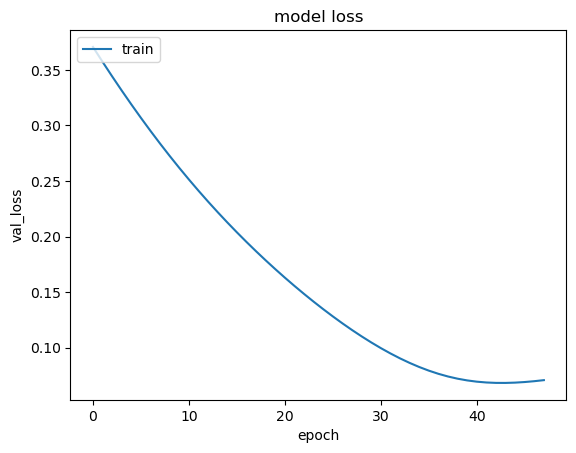

In [129]:
#notice that I'm predicting from the ENTIRE sequence, including x_train      
#is important for the model to adjust its states before predicting the end
callbacks = [
    tf.keras.callbacks.EarlyStopping(patience=patience, monitor="val_loss",min_delta=0.001)
]
history = model.fit(x_train, y_train, epochs=epochs, batch_size=1, verbose=2, validation_data=(x_test,y_test), callbacks=callbacks)
tf.keras.utils.plot_model(model, show_shapes=True)
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('val_loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

/home/esteban/anaconda3/envs/Keras/lib/python3.10/site-packages/keras/engine/training_v1.py:2356: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,



y_predict_true:
(1, 118, 1)
y_predict_model: 
(1, 118, 1)
test length: 72


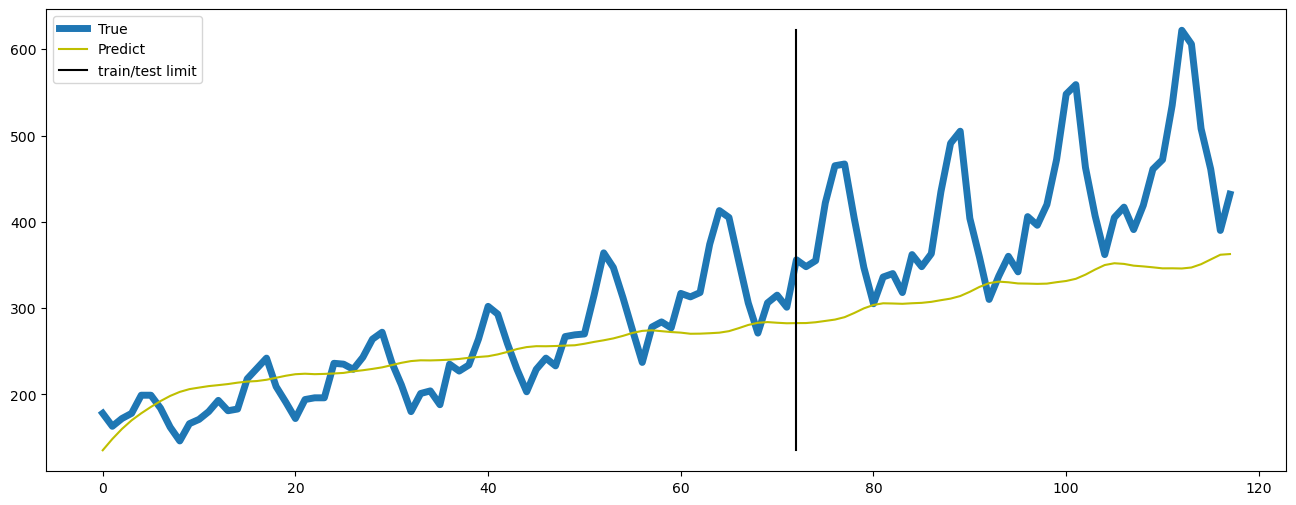

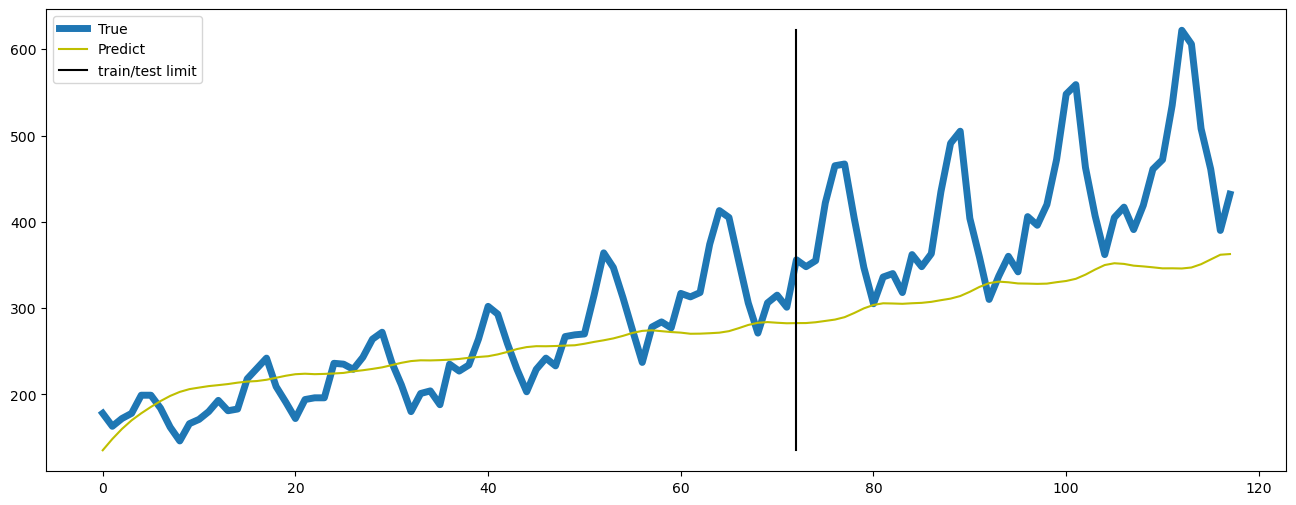

In [130]:
y_predict_model = model.predict(x_predict)

print("\ny_predict_true:")
print (y_predict_true.shape)
print("y_predict_model: ")
print (y_predict_model.shape)
# print(y_predict_true[0,:,0],y_predict_model[0,:,0])
# trainScore = np.sqrt(mean_absolute_percentage_error(y_predict_true[0,:,0], y_predict_model[0,:,0]))
# print('Train Score: %.2f MAPE' % (trainScore))


def plot(true, predicted, divider):

    predict_plot = scaler.inverse_transform(predicted[0])
    true_plot = scaler.inverse_transform(true[0])

    predict_plot = predict_plot[:,0]
    true_plot = true_plot[:,0]

    plt.figure(figsize=(16,6))
    plt.plot(true_plot, label='True',linewidth=5)
    plt.plot(predict_plot,  label='Predict',color='y')

    if divider > 0:
        maxVal = max(true_plot.max(),predict_plot.max())
        minVal = min(true_plot.min(),predict_plot.min())

        plt.plot([divider,divider],[minVal,maxVal],label='train/test limit',color='k')

    plt.legend()
    plt.show()

test_size = n_rows - train_size
print("test length: " + str(test_size))

plot(y_predict_true,y_predict_model,train_size)
plot(y_predict_true[:,-2*test_size:],y_predict_model[:,-2*test_size:],test_size)

In [131]:
from keras2cpp import export_model
export_model(model, 'example.model')